In [ ]:
#Look Ma a Spike


In [1]:
import math
import mne
from MEG_Tools import MEG
import matplotlib as plt
import numpy as np
plt.use('Qt5Agg')
meg = MEG('case_2225_with_spike_dipoles_sleep_2.mat')
mne_fif = meg.get_mne()

Creating RawArray with float64 data, n_channels=373, n_times=509000
    Range : 0 ... 508999 =      0.000 ...   508.999 secs
Ready.
Writing /Users/williamwilson/Library/CloudStorage/Dropbox/Ganz/MEG/MEG-Tools/case_2225_with_spike_dipoles_sleep_2.mat.tmp.raw.fif
Closing /Users/williamwilson/Library/CloudStorage/Dropbox/Ganz/MEG/MEG-Tools/case_2225_with_spike_dipoles_sleep_2.mat.tmp.raw.fif
[done]
Opening raw data file case_2225_with_spike_dipoles_sleep_2.mat.tmp.raw.fif...
Isotrak not found
    Range : 0 ... 508999 =      0.000 ...   508.999 secs
Ready.


In [2]:
#First we find the location of a known spike


In [3]:
known_spike_time = meg.spikes[0]['begin']
known_spike_time = int(math.floor(known_spike_time))#round to second below
known_spike_time

51

In [4]:
def round_down_to_nearest_epoch(time, epoch_length):
    # Rounds the time down to the nearest multiple of epoch_length
    return int(math.floor(time / epoch_length))


In [5]:
#Make epochs
length_of_epoch = 1 #number of seconds

sfreq = mne_fif.info['sfreq']
#events = np.array([[i, 0, 1] for i in range(0, mne_fif.n_times - int(sfreq), int(sfreq))], dtype=int)
events = np.array([[i, 0, 1] for i in range(0, mne_fif.n_times - int(length_of_epoch * sfreq), int(length_of_epoch * sfreq))], dtype=int)

#epochs = mne.Epochs(mne_fif, events, event_id={'one_sec': 1}, tmin=0, tmax=1, baseline=None, preload=True)
epochs = mne.Epochs(mne_fif, events, event_id={str(length_of_epoch)+" sec": 1}, tmin=0, tmax=3, baseline=None, preload=True)


Not setting metadata
508 matching events found
No baseline correction applied
0 projection items activated
Loading data for 508 events and 3001 original time points ...
2 bad epochs dropped


Using matplotlib as 2D backend.


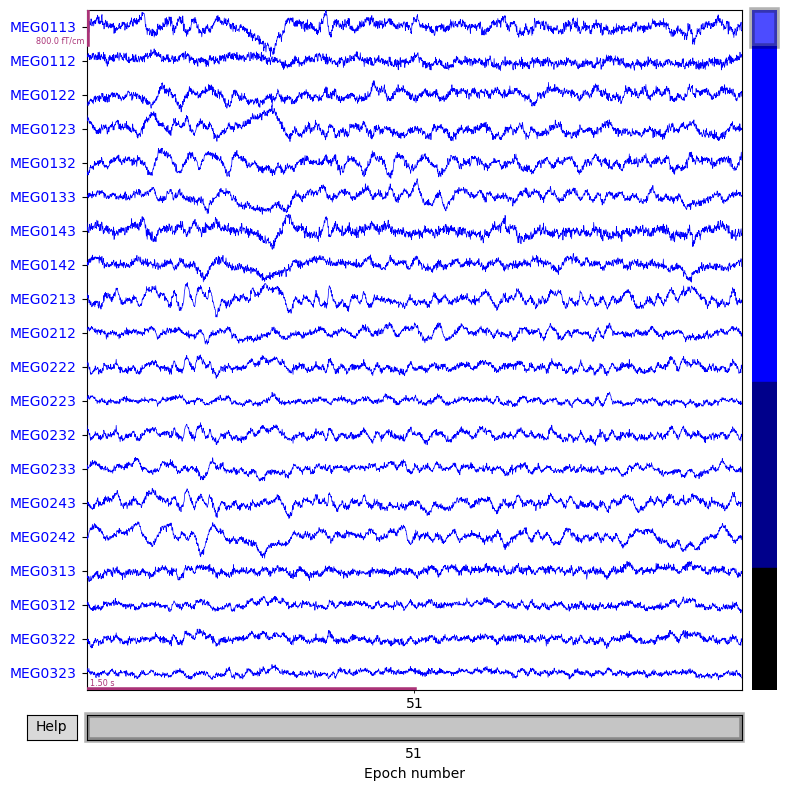

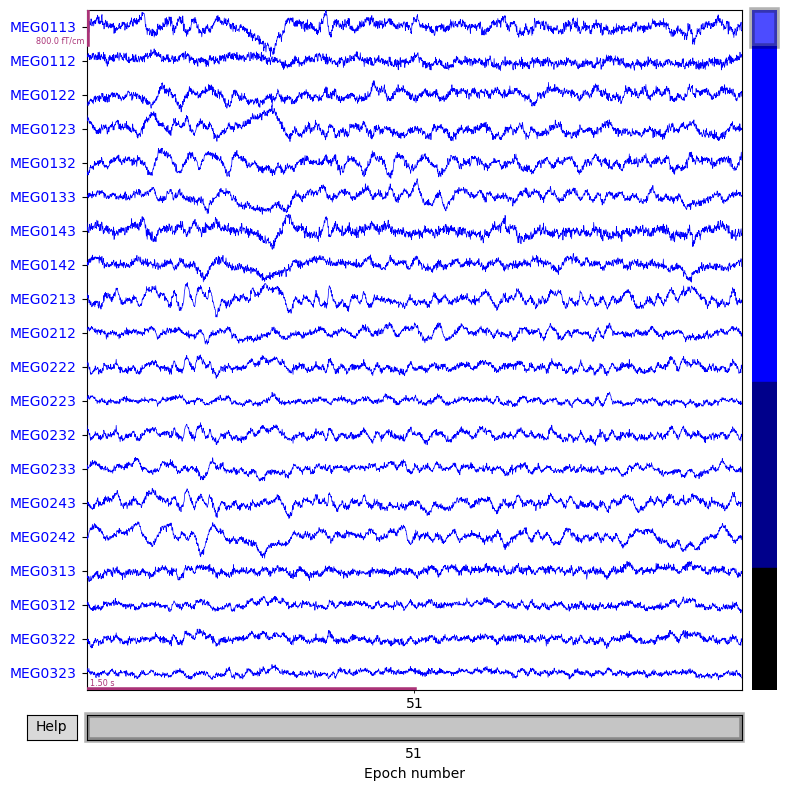

In [6]:
#Let's take a look....
first_spike = epochs[round_down_to_nearest_epoch(known_spike_time,length_of_epoch)]

# Plot the first epoch
first_spike.plot()

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.2s


No baseline correction applied


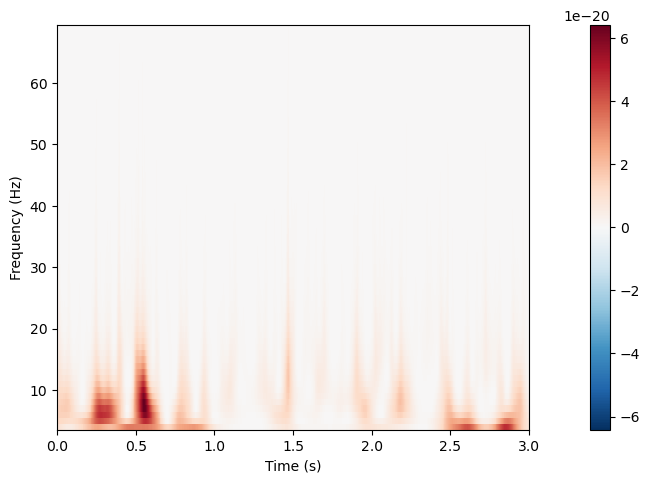

[<Figure size 640x480 with 2 Axes>]

In [7]:
#plot - Wavelet Spike
frequencies = np.arange(4, 70, 1)
spike_time = round_down_to_nearest_epoch(known_spike_time,length_of_epoch)
power = mne.time_frequency.tfr_morlet(
    epochs[spike_time:spike_time+1], n_cycles=2, return_itc=False, freqs=frequencies, decim=3
)
power.plot(["MEG0242"])

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.3s


No baseline correction applied


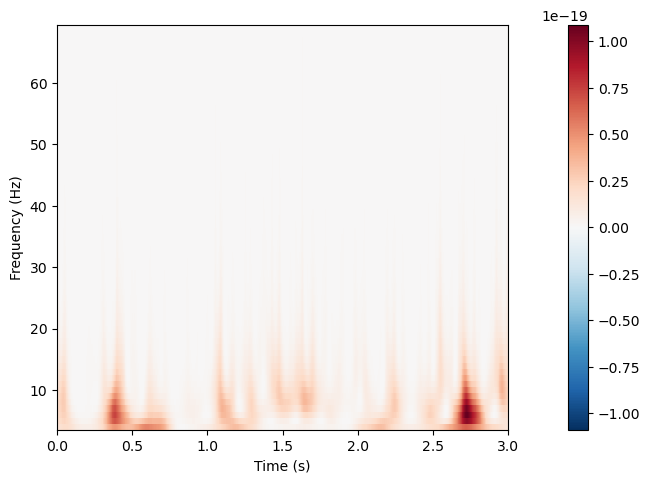

[<Figure size 640x480 with 2 Axes>]

In [8]:
#plot - Wavelet Non-Spike
frequencies = np.arange(4, 70, 1)
power = mne.time_frequency.tfr_morlet(
    epochs[length_of_epoch*3:length_of_epoch*4], n_cycles=2, return_itc=False, freqs=frequencies, decim=3
)
power.plot(["MEG0242"])

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated


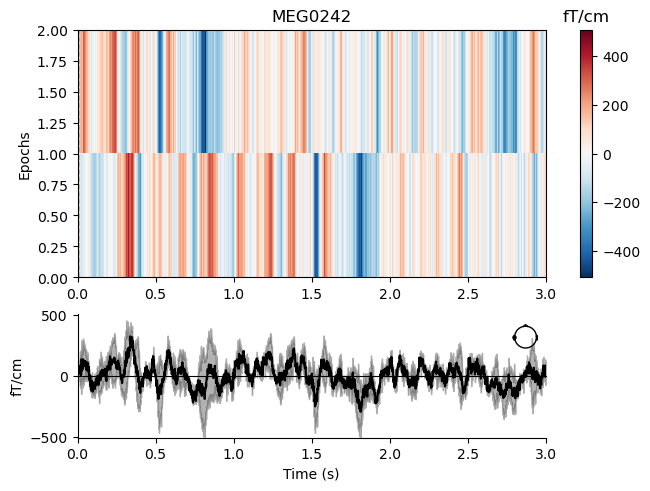

[<Figure size 640x480 with 4 Axes>]

In [9]:
#plot 
epochs[spike_time-1:spike_time+1].plot_image(picks=["MEG0242"])

In [10]:
def get_spiked_lists(epochs_,meg_):
    epochlength = round_down_to_nearest_epoch(len(epochs_), length_of_epoch)
    # Creating spiked_list from meg.spikes
    #spiked_list_ = []
    #for n in range(len(meg_.spikes)):
    #    begin = meg_.spikes[n]['begin']
    #    if (begin <= epochlength):
    #        spiked_list_.append(int(math.floor(begin)))
    spiked_list_ = []
    for spike in meg_.spikes:
        begin = spike['begin']
        rounded_begin = round_down_to_nearest_epoch(begin, length_of_epoch)
        spiked_list_.append(rounded_begin)
    
    # Remove duplicates and sort spiked_list
    spiked_list_ = sorted(list(set(spiked_list_)))
    
    # Creating unspiked_list
    unspiked_list_ = [i for i in range(epochlength) if i not in spiked_list_]
    
    spiked_epochs_ = epochs_[spiked_list_]
    unspiked_epochs_ = epochs_[unspiked_list_]
    return (spiked_list_,unspiked_list_,spiked_epochs_,unspiked_epochs_)



In [11]:
(spiked_list,unspiked_list,spiked_epochs, unspiked_epochs) = get_spiked_lists(epochs,meg)

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"


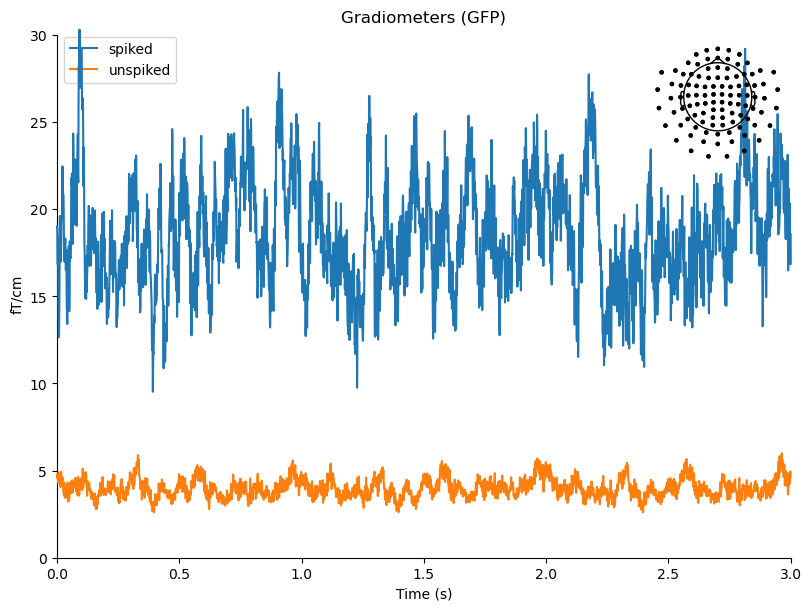

combining channels using "gfp"
combining channels using "gfp"


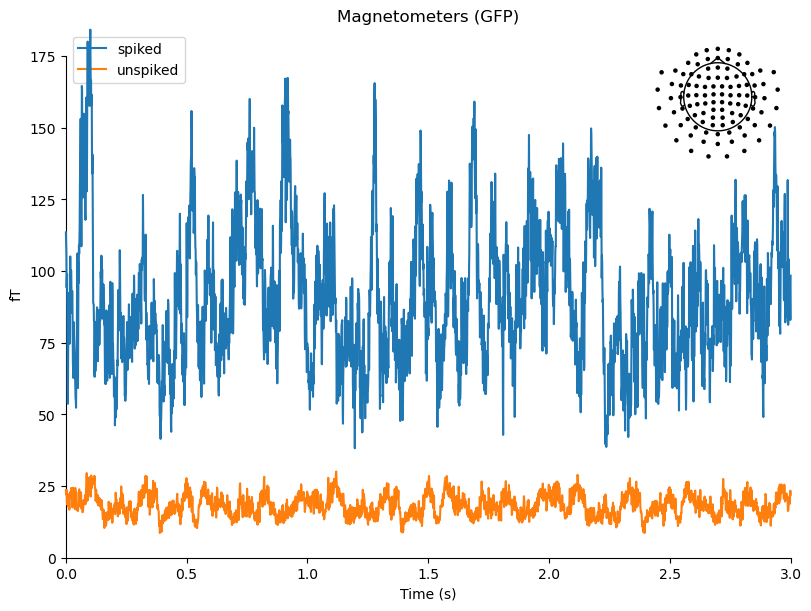

combining channels using "gfp"
combining channels using "gfp"


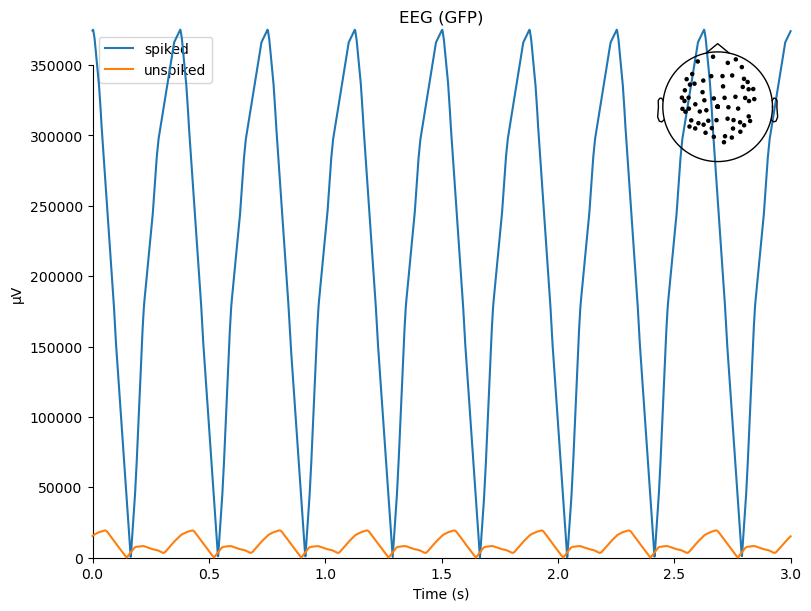

[<Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>,
 <Figure size 800x600 with 2 Axes>]

In [12]:
#Plot
#GFP - "Global Field Power"
#GFP is calculated by summing the squared signals from all sensors or channels across the scalp or head. 
#It can be used to analyze and visualize the overall intensity of brain activity, 
#helping researchers identify periods of high neural engagement or specific brain regions that are 
#particularly active during certain tasks or conditions.

spiked_evoked = spiked_epochs.average()
unspiked_evoked = unspiked_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(spiked=spiked_evoked, unspiked=unspiked_evoked),
    legend="upper left",
    show_sensors="upper right",
)

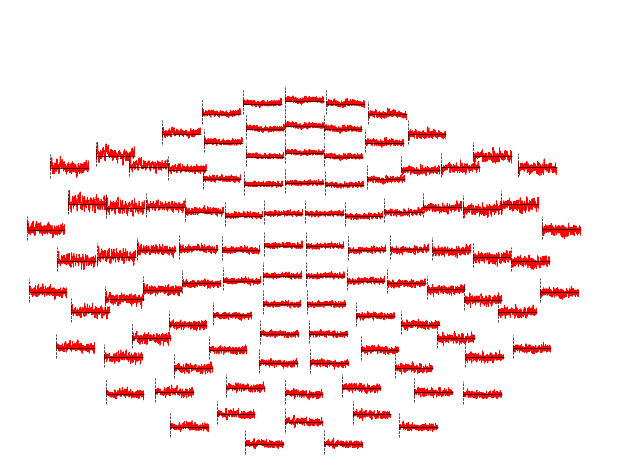

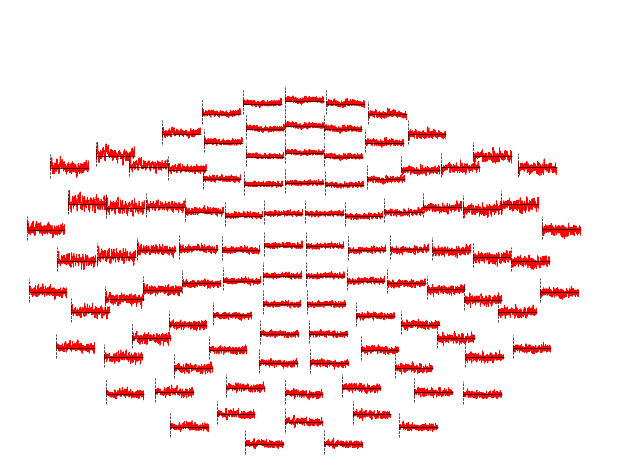

In [13]:
#Plot
evoked_diff = mne.combine_evoked([spiked_evoked, unspiked_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

No projector specified for this dataset. Please consider the method self.add_proj.


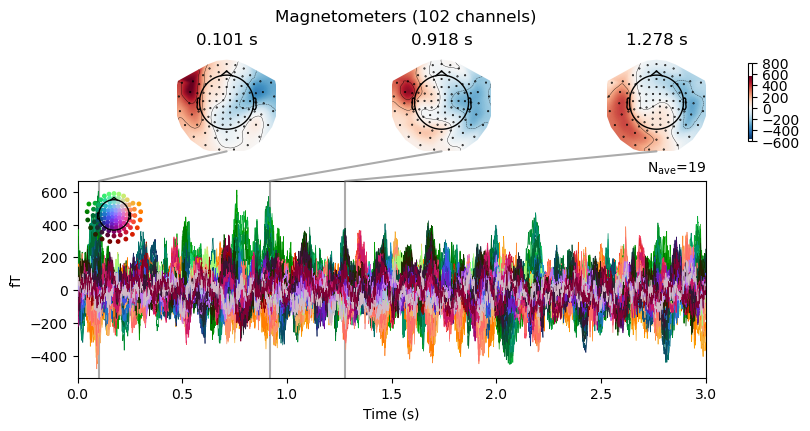

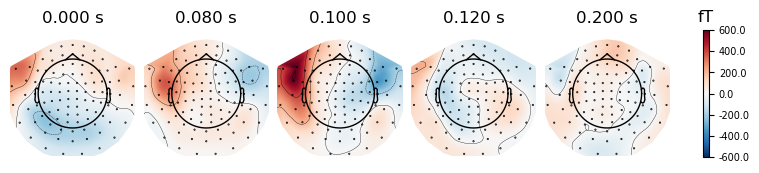

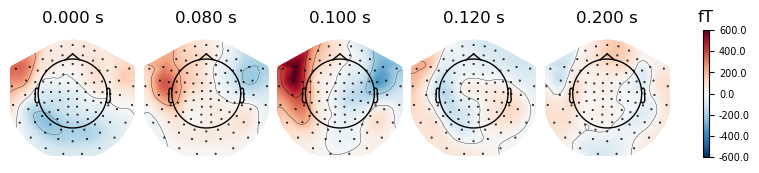

In [14]:
#Plot - Hmmmm
spiked_evoked.plot_joint(picks="mag")
spiked_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="mag")

## Clustering

In [15]:
import functools
import time
import pywt
from scipy.stats import skew, kurtosis  # Importing skew and kurtosis

In [16]:
print(pywt.wavelist(kind='discrete'))
print('')
for family in pywt.families():
    print (f'{family} family {pywt.wavelist(family=family)}')

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']

haar family ['haar']
db family ['

In [17]:


def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

def get_labels(spiked_list_,unspiked_list_):
    # Total number of epochs (assuming the highest value from either list is the last epoch)
    total_epochs = max(spiked_list_ + unspiked_list_) + 1  # +1 because lists are 0-indexed
    
    # Initialize a list with zeros (assuming all epochs are initially unspiked)
    labels_ = [0] * total_epochs
    
    # Set the spiked epochs to 1
    for index in spiked_list_:
        labels_[index] = 1
    return labels_

#custom wavelet
def morlet_wavelet(width=5):
    t = np.linspace(-2.5, 2.5, width)
    real = np.cos(5 * t)
    imag = np.sin(5 * t)
    morlet = real + 1j * imag
    return morlet / np.linalg.norm(morlet)


#Create a custom wavelet
morlet_coeffs = morlet_wavelet(width=10)
custom_wavelet = pywt.Wavelet(name="CustomMorlet", filter_bank=[morlet_coeffs.real, morlet_coeffs.imag, morlet_coeffs.real, morlet_coeffs.imag])


@timer
def get_features(epochs_):
    
    features_ = []
    #mne.set_log_level('WARNING')
    
    for n in range(len(epochs_)):
        # Progress indicator
        perc = np.round(100 * n / len(epochs_), 1)
        print(f"Progress: {perc}%", end='\r', flush=True)

        data = epochs_[n].get_data(copy=False)[0]

        # Apply Discrete Wavelet Transform
        #coeffs = pywt.wavedec(data, wavelet='db4', level=4)  # Example: 4-level decomposition
        coeffs = pywt.wavedec(data, wavelet='rbio6.8', level=4)  # Reverse Biorthogonal
        
        #for custom wavelet
        
        #Use the custom wavelet in wavedec
        #coeffs = pywt.wavedec(data, wavelet=custom_wavelet, level=6)

        
        epoch_features = []
        # Calculate features for each coefficient level
        for coeff in coeffs:
            # Here, ensure that each feature extracted is a single value and not an array
            energy = np.sum(coeff**2)
            mean_coeff = np.mean(coeff)
            var_coeff = np.var(coeff)
            skew_coeff = skew(coeff)
            kurt_coeff = kurtosis(coeff)

            # Append each feature to epoch_features
            epoch_features.extend([energy, mean_coeff, var_coeff, skew_coeff, kurt_coeff])

        # Append the feature set for this epoch to features_
        features_.append(epoch_features)
    return features_
print('')


In [18]:

features = get_features(epochs)
labels = get_labels(spiked_list,unspiked_list)


Elapsed time: 14.8642 seconds


In [19]:
def flatten_mixed_list(mixed_list):
    flattened_list = []
    for item in mixed_list:
        if isinstance(item, list) or isinstance(item, np.ndarray):
            # If the item is a list or numpy array, extend the flattened list with the flattened item
            flattened_list.extend(flatten_mixed_list(item))
        else:
            # If the item is not a list, just append it to the flattened list
            flattened_list.append(item)
    return flattened_list


for n in range(len(features)):
    features[n] = flatten_mixed_list(features[n])

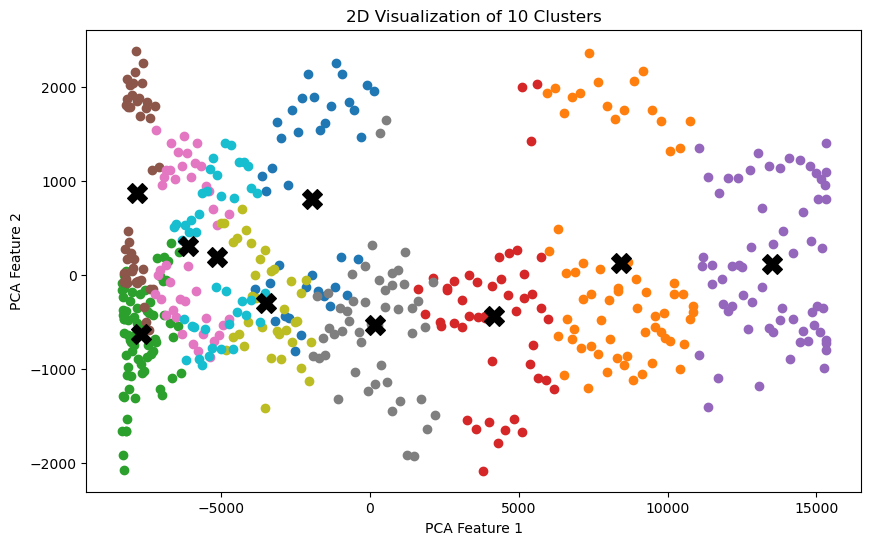

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

spiked_labels = labels.copy()
n_clusters = 10 
# Apply K-means Clustering with clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 'auto').fit(features)
cluster_labels = kmeans.labels_

# Reduce the feature dimensions to 2D using PCA
#PCA refers to Principal Component Analysis. PCA is a statistical technique used for dimensionality reduction
#The first principal component (PC1) is oriented in the direction of the greatest variance in the data. 
#It captures the largest amount of total variability present in the original features. 
#The second principal component (PC2) is orthogonal (perpendicular) to the first and captures 
#the next largest amount of variance, and so on. This process continues for each subsequent principal component.

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Scatter plot of the seven clusters
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    mask = (cluster_labels == cluster)
    plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1], label=f'Cluster {cluster}')

# Optionally, plot the centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='k', label='Centroids')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title(f'2D Visualization of {n_clusters} Clusters')
#plt.legend()
plt.show()





In [21]:
# Counting spiked instances in each cluster
for cluster in range(n_clusters):
    # Counting spiked instances in the current cluster
    this_cluster_spiked_count = sum(spiked_labels[n] for n in range(len(spiked_labels)) if cluster_labels[n] == cluster)
    print(f"Cluster {cluster} contains {this_cluster_spiked_count} spiked instances")

Cluster 0 contains 2 spiked instances
Cluster 1 contains 4 spiked instances
Cluster 2 contains 5 spiked instances
Cluster 3 contains 2 spiked instances
Cluster 4 contains 3 spiked instances
Cluster 5 contains 0 spiked instances
Cluster 6 contains 0 spiked instances
Cluster 7 contains 1 spiked instances
Cluster 8 contains 1 spiked instances
Cluster 9 contains 1 spiked instances
